<a href="https://colab.research.google.com/github/prakashgyan/NLP/blob/master/Disater_tweets_classifcation_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd 
import numpy as np
from tqdm import tqdm
import pickle
import re
import string
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import tensorflow as tf
import keras.backend as K
from keras.models import Model
from keras.layers import Input,Layer
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU,SimpleRNN
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

import matplotlib.pyplot as plt

In [ ]:
# Detect hardware, return appropriate distribution strategy
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
try:
    print('Running on TPU ', tpu.master())

except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    

Running on TPU  grpc://10.84.201.242:8470
INFO:tensorflow:Initializing the TPU system: grpc://10.84.201.242:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.84.201.242:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


In [ ]:
PATH  = '/content/drive/My Drive/Colab_Data/DTweets/'

In [ ]:
train = pd.read_csv(f'{PATH}train.csv')
test = pd.read_csv(f'{PATH}test.csv')
sample_submission = pd.read_csv(f'{PATH}sample_submission.csv')

In [ ]:
train.drop(['keyword','location','id'],axis=1,inplace=True)
# test.drop(['keyword','location','id'],axis=1,inplace=True)

In [ ]:
train.text.apply(lambda x : len(str(x).split())).max()
test.text.apply(lambda x : len(str(x).split())).max()


31

In [ ]:
#Cleaning DAta 

def clean_all(text):
  text = re.sub(r'http\S+', '', text)
  table = str.maketrans('', '', string.punctuation)
  text = text.translate(table)
  return text

In [ ]:
train['text'] = train.text.apply(clean_all)
test['text'] = test.text.apply(clean_all)

In [ ]:
xtrain,xvalid,ytrain,yvalid = train_test_split(train.text.values,
                                               train.target.values,
                                               stratify=train.target.values,
                                               random_state=42,test_size=0.2,
                                               shuffle=True)

In [ ]:
token = text.Tokenizer(oov_token='<OOV>')

In [ ]:
max_length = 32

In [ ]:
token.fit_on_texts(list(xtrain) + list(xvalid) + list(xtest))

In [ ]:
xtrain_seq = token.texts_to_sequences(xtrain)
xvalid_seq = token.texts_to_sequences(xvalid)
xtest_seq = token.texts_to_sequences(xtest)

#zero pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_length)
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_length)
xtest_pad = sequence.pad_sequences(xtest_seq, maxlen=max_length)

In [ ]:
xtrain_pad.shape

(6090, 32)

In [ ]:
word_index = token.word_index

In [ ]:
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

In [ ]:
from zipfile import ZipFile
file_name = '/content/drive/My Drive/glove.840B.300d.zip'
with ZipFile(file_name, 'r') as zip: 
    # printing all the contents of the zip file 
    zip.printdir()
    # extracting all the files 
    print('Extracting all the files now...') 
    zip.extractall() 
    print('Done!') 

File Name                                             Modified             Size
glove.840B.300d.txt                            2015-10-24 10:35:30   5646236541
Extracting all the files now...
Done!


In [ ]:
embeddings_index = {}
f = open('glove.840B.300d.txt','r',encoding='utf-8')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))


2196017it [03:26, 10640.56it/s]

Found 2196016 word vectors.


In [ ]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 22810/22810 [00:00<00:00, 313259.88it/s]


Adding an Attention Layer

In [ ]:
class attention(Layer):
    def __init__(self,**kwargs):
        # super(Linear, self).__init__()
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

In [ ]:
%%time
with strategy.scope():   
    inputs = Input((max_length,))
    x = Embedding(len(word_index) + 1,
                        300,
                        weights=[embedding_matrix],
                        input_length=max_length,
                        trainable=False)(inputs)
    x = Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.2, return_sequences=True))(x)   
    x = attention()(x)
    output = Dense(1,activation='sigmoid')(x)

    model1 = Model(inputs,output)
    model1.compile(loss='binary_crossentropy', optimizer=Adam(),metrics=['accuracy',f1])

model1.summary()


Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 32)                0         
_________________________________________________________________
embedding_25 (Embedding)     (None, 32, 300)           6843300   
_________________________________________________________________
bidirectional_20 (Bidirectio (None, 32, 600)           1442400   
_________________________________________________________________
attention_14 (attention)     (None, 600)               632       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 601       
Total params: 8,286,933
Trainable params: 1,443,633
Non-trainable params: 6,843,300
_________________________________________________________________
CPU times: user 1.94 s, sys: 724 ms, total: 2.67 s
Wall time: 4.11 s


In [ ]:
%%time
with strategy.scope():
    # A simple bidirectional LSTM with glove embeddings and one dense layer
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_length,
                     trainable=False))
    model.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.2))) 
    # model.add(attention)   
    # model.add(Dense(6,activation='relu'))
    model.add(Dense(1,activation='sigmoid'))
    # opt = tf.keras.optimizers.Adam()
    model.compile(loss='binary_crossentropy', optimizer=Adam(),metrics=['accuracy',f1])
    
    
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 32, 300)           6843300   
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 600)               1442400   
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 601       
Total params: 8,286,301
Trainable params: 1,443,001
Non-trainable params: 6,843,300
_________________________________________________________________
CPU times: user 1.46 s, sys: 572 ms, total: 2.03 s
Wall time: 3.71 s


In [ ]:
model.fit(xtrain_pad, ytrain, epochs=4, batch_size=64*strategy.num_replicas_in_sync,validation_data=(xvalid_pad,yvalid))

Train on 6090 samples, validate on 1523 samples
Epoch 1/4
6090/6090 [==============================] - 9s 1ms/step - loss: 0.5680 - accuracy: 0.7034 - f1: 0.6154 - val_loss: 0.4551 - val_accuracy: 0.8135 - val_f1: 0.7744
Epoch 2/4
6090/6090 [==============================] - 8s 1ms/step - loss: 0.4552 - accuracy: 0.7980 - f1: 0.7448 - val_loss: 0.4320 - val_accuracy: 0.8221 - val_f1: 0.7807
Epoch 3/4
6090/6090 [==============================] - 8s 1ms/step - loss: 0.4279 - accuracy: 0.8148 - f1: 0.7657 - val_loss: 0.4105 - val_accuracy: 0.8267 - val_f1: 0.7888
Epoch 4/4
6090/6090 [==============================] - 8s 1ms/step - loss: 0.4116 - accuracy: 0.8222 - f1: 0.7797 - val_loss: 0.4105 - val_accuracy: 0.8247 - val_f1: 0.7798


In [ ]:
history = model1.fit(xtrain_pad, ytrain, epochs=7, batch_size=64*strategy.num_replicas_in_sync,validation_data=(xvalid_pad,yvalid))

Train on 6090 samples, validate on 1523 samples
Epoch 1/7
6090/6090 [==============================] - 10s 2ms/step - loss: 0.5730 - accuracy: 0.7146 - f1: 0.5813 - val_loss: 0.4507 - val_accuracy: 0.8050 - val_f1: 0.7580
Epoch 2/7
6090/6090 [==============================] - 9s 1ms/step - loss: 0.4528 - accuracy: 0.7951 - f1: 0.7405 - val_loss: 0.4288 - val_accuracy: 0.8234 - val_f1: 0.7805
Epoch 3/7
6090/6090 [==============================] - 9s 1ms/step - loss: 0.4264 - accuracy: 0.8161 - f1: 0.7683 - val_loss: 0.4147 - val_accuracy: 0.8267 - val_f1: 0.7789
Epoch 4/7
6090/6090 [==============================] - 9s 1ms/step - loss: 0.4160 - accuracy: 0.8181 - f1: 0.7665 - val_loss: 0.4110 - val_accuracy: 0.8227 - val_f1: 0.7830
Epoch 5/7
6090/6090 [==============================] - 9s 1ms/step - loss: 0.4043 - accuracy: 0.8207 - f1: 0.7782 - val_loss: 0.4085 - val_accuracy: 0.8286 - val_f1: 0.7789
Epoch 6/7
6090/6090 [==============================] - 9s 1ms/step - loss: 0.4051 - ac

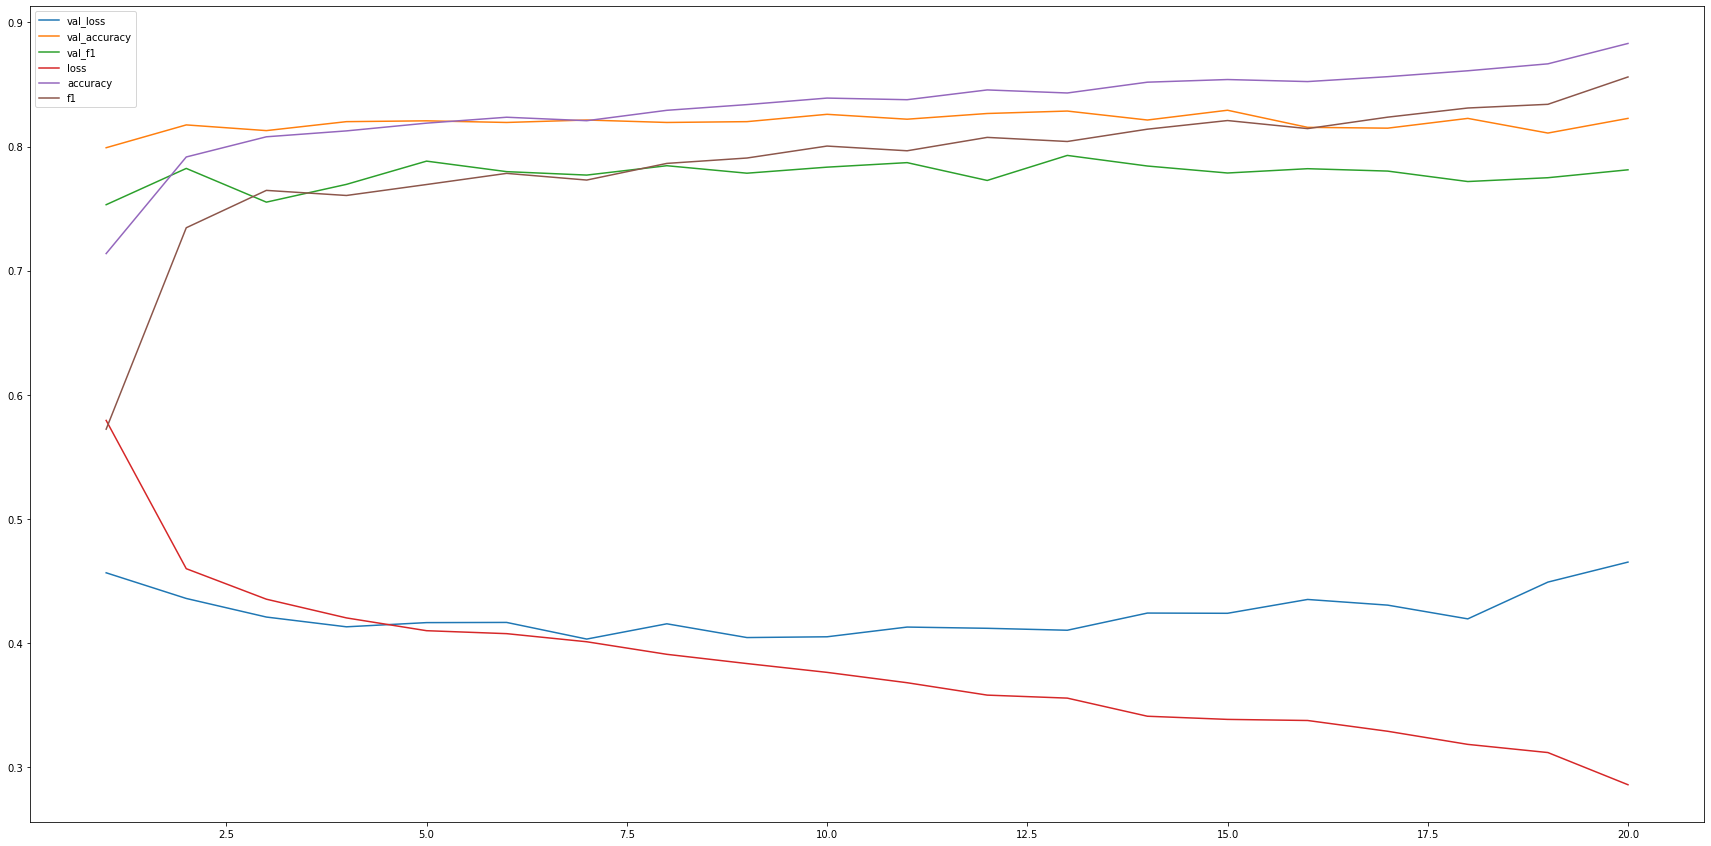

In [ ]:
fig ,axs = plt.subplots(facecolor='white',figsize=(30,15))
for item in history.history:
    axs.plot(range(1,21),history.history[item])

axs.legend([item for item in history.history])

In [ ]:
xtest_pad

array([[   0,    0,    0, ..., 1496,  125,   86],
       [   0,    0,    0, ...,  641, 1435,  250],
       [   0,    0,    0, ...,  351,   91,   40],
       ...,
       [   0,    0,    0, ...,  418,    5, 1273],
       [   0,    0,    0, ...,  253, 1710, 1828],
       [   0,    0,    0, ...,   72,  239, 3518]], dtype=int32)

In [ ]:
preds = model1.predict(xtest_pad)

In [ ]:
test['target'] = np.round(preds).astype(int)

In [ ]:
test

,id,keyword,location,text,target
0,0,NaN,NaN,Just happened a terrible car crash,1
1,2,NaN,NaN,Heard about earthquake is different cities sta...,1
2,3,NaN,NaN,there is a forest fire at spot pond geese are ...,1
3,9,NaN,NaN,Apocalypse lighting Spokane wildfires,1
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,1
...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,1
3259,10865,NaN,NaN,Storm in RI worse than last hurricane My citya...,1
3260,10868,NaN,NaN,Green Line derailment in Chicago,1
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook HWO,1


In [ ]:
test.drop(['text','keyword','location'],axis=1).to_csv('DT_Submission.csv',index=False)